# Official data processing

### Inputs
* BRES data downloaded from Nomis
* IDBR data downloaded from Nomis (including data about size distributions)
* IDBR data obtained from Frontier Economics
* ABS data obtained from Frontier Economics


### Outputs
A collection of tables with information about creative sectors and subsectors at the right level of detail (TTWA, region) and in a tidy format



## Preamble

In [1]:
%matplotlib inline
#Imports

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models')

#Visualisations
viz_path = os.path.join(top,'src/visualization')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [2]:
# Classes

class BresData():
    '''
    This class processes data downloaded from BRES. This includes...
    -Reading the data and removing irrelevant info at the top and bottom
    -Removing disclosure columns
    -Clean up column names
    -Option to gather data over a selected set of codes (e.g. creative industries codes)
    -Generate LQs
    
    We assume that the rows are locations (eg TTWAs and the columns are industries)
    
    '''
    
    def __init__(self,file,year):
        '''
        Initialise the class
        
        '''
        
        #File name
        self.file_name = file
        self.year=year
        
    def read_clean_data(self,rows_to_skip=8):
        '''
        Read the data and metadata
        
        '''
        #Read the data. NB we had a look to determine how many files to skip
        raw_data = pd.read_csv(self.file_name,skiprows=rows_to_skip,na_values='-')
        
        #Find the column with totals...
        last_row = list(raw_data.iloc[:,0]).index('Column Total')
        
        #...and remove
        raw_data = raw_data.loc[:last_row-1,:]
        
        #Remove unnamed columns
        clean_data = raw_data.loc[:,['Unnamed' not in x for x in raw_data.columns]]
        
        #Clean variable names:
        #Clean the sics (only leave the numbers - careful with the str/int thing though!)
        clean_names = [x.split(':')[0].strip() if ':' in x else x for x in clean_data.columns]
        
        clean_names[0] = 'ttwa_name'
        clean_names[1] = 'ttwa_code'
        
        clean_data.columns = clean_names
        
        self.processed_data = clean_data
        
        return(self)
        
    def gather_by_sector(self,sector_lookup,sector_totals=True,sector_name='creative_industries'):
        '''
        
        We gather the data by sector. The gathering is based on a lookup matching sic codes to sectors
        to aggregate over. We also extract LQs
        
        '''
        #Load data
        data = self.processed_data
        
        #Melt and gather
        data_long = pd.merge(pd.melt(data,id_vars=['ttwa_name','ttwa_code'],var_name='sic'),
                             sector_lookup,left_on='sic',right_on='sic',how='outer')
        
        data_long['sector'].fillna('not_in_sector',inplace=True) 
        
        #Pivot to generate the aggregates
        data_wide = pd.pivot_table(data_long,index=['ttwa_name','ttwa_code'],columns='sector',
                                  values='value',aggfunc='sum')
        
        
        #If we decided we wanted aggregates for the whole sector, we do that:
        
        if sector_totals==True:
            #If sector totals is true, aggregate over them
            data_wide[sector_name] = data_wide.loc[:,[
                x for x in data_wide.columns if x!='not_in_sector']].sum(axis=1)
            
    
        #Also extract LQs (using the create_lq utility function)
        self.gathered_data_lq = create_lq_df(data_wide) 

        data_wide['year'] = self.year
        self.gathered_data = data_wide
        
        return(self)
    
class QueryNomis():
    '''
    This class queries the Nomis API. It takes an API link extracted from the Nomis interface
    and the total number of records (which is used for pagination)
    
    '''
    
    def __init__(self,link,total_records):
        '''
        Initialise with links and the total number of records
    
        '''
        
        self.link = link
        self.total_records = total_records
    
    #We use this decorator to be nice to the API
    @ratelim.patient(60,time_interval=60)
    def query_nomis(self):
        '''
        This method queries nomis for the data in the API. 
        We keep things simple by using the pandas read_csv function directly
        
        '''
        
        #Link
        link = self.link
        
        #DF container
        df_container =[]
        
        #Counters
        offset = 0
        records_left = self.total_records
        
        
        #While the final record we will obtain is below the total number of records:
        while(records_left>0):
            
            print(records_left)            
            
            #Modify the query link with the offset
            query_link = link+'&recordoffset={off}'.format(off=str(offset))
            
            #Run query
            output = pd.read_csv(query_link)
            
            #Append output to our container list
            df_container.append(output)
            
            #Update the offset (next time we will query from this point)
            offset+=25000
            
            #This is the number of records left to collect
            records_left-=25000
        
        #Concatenate all the outputs
        final_df = pd.concat(df_container)
        
        #Get it out
        self.output_data= final_df

In [3]:
#Functions

def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

# Load Data

### Load metadata

In [4]:
#Load the sic-creative lookup
creative_lookup = pd.read_csv(ext_data+'/ce_codes.csv')

#Remove SOC codes and detailed SIC labels
creative_lookup = creative_lookup.loc[creative_lookup.type=='SIC',['code','label2']]

#Rename label2 into sector
creative_lookup.rename(columns={'label2':'sector',
                               'code':'sic'},inplace=True)

creative_lookup['sic'] =[str(x) for x in creative_lookup['sic']]

### Extract BRES data

In [5]:
#Extract bres_data
bres_data = [BresData(ext_data+'/bres_{y}.csv'.format(
    y=x),year=x).read_clean_data().gather_by_sector(creative_lookup) for x in ['2015','2016']]


bres_totals_df = pd.concat([x.gathered_data for x in bres_data])

bres_totals_df.to_csv(ext_data+'/bres_creative_2015_16.csv')

In [6]:
#Extract bres_data with employees
bres_data_employees = [BresData(ext_data+'/bres_employees_{y}.csv'.format(
    y=x),year=x).read_clean_data().gather_by_sector(creative_lookup) for x in ['2015','2016']]


bres_totals_employees_df = pd.concat([x.gathered_data for x in bres_data_employees])

#bres_totals_df.to_csv(ext_data+'/bres_creative_2015_16.csv')

In [7]:
#Create averages between employees and employment
bres_totals_combined = pd.merge(pd.melt(bres_totals_df.reset_index(drop=False),id_vars=['ttwa_name','ttwa_code','year'],
                               value_name='employment'),
                       pd.melt(bres_totals_employees_df.reset_index(drop=False),id_vars=['ttwa_name','ttwa_code','year'],
                               value_name='employees'),
                       left_on=['ttwa_name','ttwa_code','year','sector'],
                                right_on=['ttwa_name','ttwa_code','year','sector'])

bres_totals_combined['employment_average'] = np.round(
    (bres_totals_combined.employment+bres_totals_combined.employees)/2)

bres_totals_combined_df = pd.pivot_table(bres_totals_combined,
                               index=['ttwa_name','ttwa_code','year'],
                               columns='sector',values='employment_average')

bres_totals_combined_df.to_csv(ext_data+'/bres_creative_combined_2015_16.csv')

### Load IDBR data

Load IDBR data collected by frontier economics. We need to output it in a similar format to BRES / IDBR above


In [103]:
def rename_columns(df, old_names,new_names):
    '''
    This function renames a columns names
    '''
    
    df.rename(columns={x:y for x,y in zip(old_names,new_names)},inplace=True)
    
ttwa_codes_names_lookup = pd.read_excel(ext_data+'/frontier/'+'spd-creative clusters counts and LQs-LU-04-01-2018.xlsx',
                           sheetname=6)[['TTWA11CD','TTWA11NM']]

ttwa_codes_names_lookup = {x:y for x,y in zip(ttwa_codes_names_lookup.TTWA11CD,ttwa_codes_names_lookup.TTWA11NM)}

/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [110]:
#Load IDBR data for the most recent period

#NB this currently are the local units

idbr_fe_subs = pd.read_excel(ext_data+'/frontier/spd-creative clusters counts and LQs-13-12-2017 (1).xlsx',
                            sheetname=4)

idbr_fe_ce = pd.read_excel(ext_data+'/frontier/spd-creative clusters counts and LQs-13-12-2017 (1).xlsx',
                            sheetname=3)

idbr_fe = pd.concat([idbr_fe_subs,idbr_fe_ce])

#We need to do three things: extract subsectoral totals, combine with creative totals and not in sector
#totals
idbr_fe_means = idbr_fe.groupby(
    ['TTWA name','TTWA code','industry'])[['Number of enterprises','Employment']].mean().reset_index(drop=False)


#Sector totals
idbr_fe_all = idbr_fe.groupby(['TTWA name','TTWA code'])['Total number of enterprises in area',
                                          'Total employment in area'].mean().reset_index(drop=False)

#Some changes in variables etc to merge without problems
idbr_fe_all['industry'] = 'not_creative'

idbr_fe_all.rename(columns={'Total employment in area':'Employment',
                           'Total number of enterprises in area':'Number of enterprises'},inplace=True)

#Combine everything
idbr_fe_all_2015_2016 = pd.concat([idbr_fe_means,idbr_fe_all])


idbr_fe_all_2015_2016['year'] = '2015_2016'

#Rename columns
rename_columns(idbr_fe_all_2015_2016,['Employment','Number of enterprises','TTWA code','TTWA name'],
              ['employment','business_count','ttwa_code','ttwa_name'])

idbr_fe_all_2015_2016.industry.value_counts()

/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


All creative industries                        225
not_creative                                   225
IT, software and computer services             154
Music, performing and visual arts              153
Architecture                                   147
Design: product, graphic and fashion design    145
Film, TV, video, radio and photography         144
Advertising and marketing                      140
Publishing                                     123
Name: industry, dtype: int64

In [111]:
#NB these are enterprises!
#Now we want to load older data (e.g period 2010-14)
idbr_fe_old = pd.read_excel(ext_data+'/frontier/'+'spd - data for creative clusters - enterprise unit - 15-02-16.xls',
                           sheetname=8,skiprows=2).loc[:,['Industry',
                                                          'TTWA 2011 code (last ONS revision Feb 2016)',
                                                          'TTWA 2011 name (last ONS revision Feb 2016',
                                                          'Business count',
                                                          'Employment']]


rename_columns(idbr_fe_old,['Industry',
                            'TTWA 2011 code (last ONS revision Feb 2016)',
                            'TTWA 2011 name (last ONS revision Feb 2016',
                            'Business count',
                            'Employment'], #Need to change Employment to Average employment
               ['industry','ttwa_code','ttwa_name','business_count','employment'])

idbr_fe_old['year']='2011_2014'

#Now we want to analyse the area totals
idbr_fe_totals = pd.read_excel(ext_data+'/frontier/'+'spd - data for creative clusters - enterprise unit - 15-02-16.xls',
                           sheetname=8,skiprows=2).iloc[:,1:]


idbr_fe_totals = idbr_fe_totals.loc[idbr_fe_totals.Industry=='All creative industries',:].reset_index(drop=True)


#We divide the share of a sector in an area by the level of activity in the area
idbr_fe_totals['employment'] = idbr_fe_totals['Employment']/idbr_fe_totals[ #Need to change Employment there
    'Proportion of local employment in sector']
idbr_fe_totals['business_count'] = idbr_fe_totals['Business count']/idbr_fe_totals[
    'Proportion of local enterprises in sector']

idbr_fe_totals = idbr_fe_totals[['TTWA 2011 code (last ONS revision Feb 2016)',
                                 'TTWA 2011 name (last ONS revision Feb 2016',
                                 'employment','business_count']]

rename_columns(idbr_fe_totals,['TTWA 2011 code (last ONS revision Feb 2016)',
                               'TTWA 2011 name (last ONS revision Feb 2016'],
               ['ttwa_code','ttwa_name'])

idbr_fe_totals['year'] = '2011_2014'
idbr_fe_totals['industry'] = 'not_creative'

#Now...

idbr_fe_all_2011_14 = pd.concat([idbr_fe_old,idbr_fe_totals])


/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [112]:
#Combine everything

idbr_fe_out = pd.concat([idbr_fe_all_2015_2016,idbr_fe_all_2011_14]).reset_index(drop=True)

idbr_fe_out.head()

,business_count,employment,industry,ttwa_code,ttwa_name,year
0,65.0,190.0,Advertising and marketing,S22000047,Aberdeen,2015_2016
1,1247.5,3635.0,All creative industries,S22000047,Aberdeen,2015_2016
2,182.5,495.0,Architecture,S22000047,Aberdeen,2015_2016
3,110.0,205.0,"Design: product, graphic and fashion design",S22000047,Aberdeen,2015_2016
4,82.5,205.0,"Film, TV, video, radio and photography",S22000047,Aberdeen,2015_2016


In [113]:
idbr_fe_out.to_csv(ext_data+'/frontier/{date}_idbr_frontier.csv'.format(date=today_str),index=False)

In [114]:
idbr_fe_out.year.value_counts()

2011_2014    2042
2015_2016    1456
Name: year, dtype: int64

Architecture
IT, software and computer services
All creative industries
Music, performing and visual arts
not_creative
Advertising and marketing
Publishing
Film, TV, video, radio and photography
Design: product, graphic and fashion design


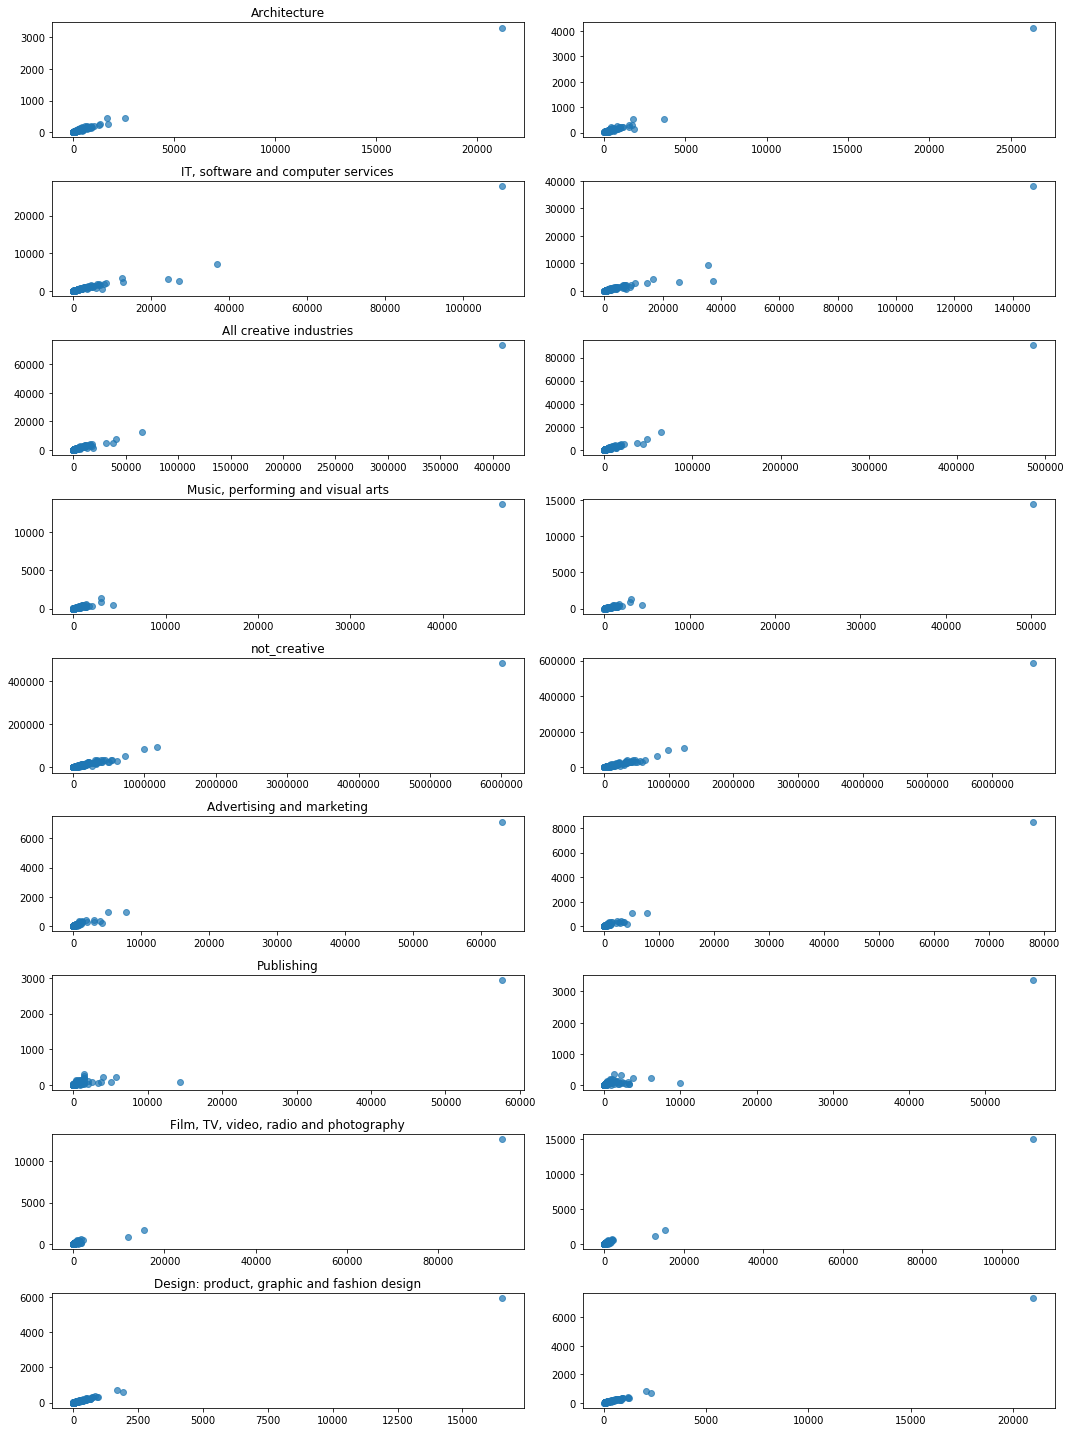

In [115]:
fig, ax = plt.subplots(nrows=len(set(idbr_fe_out.industry)),ncols=2,figsize=(15,20))


for num,x in enumerate(set(idbr_fe_out.industry)):
    print(x)
    
    data = idbr_fe_out.loc[idbr_fe_out.industry==x,:]
    
    ax[num][0].scatter(data.loc[data.year=='2011_2014',
                             'employment'],
                    data.loc[data.year=='2011_2014',
                             'business_count'],alpha=0.7)
    
    ax[num][0].set_title(x)
    
    ax[num][1].scatter(data.loc[data.year=='2015_2016',
                             'employment'],
                    data.loc[data.year=='2015_2016',
                             'business_count'],alpha=0.7)
    
    
plt.tight_layout()

Architecture
IT, software and computer services
All creative industries
Music, performing and visual arts
not_creative
Advertising and marketing
Publishing
Film, TV, video, radio and photography
Design: product, graphic and fashion design


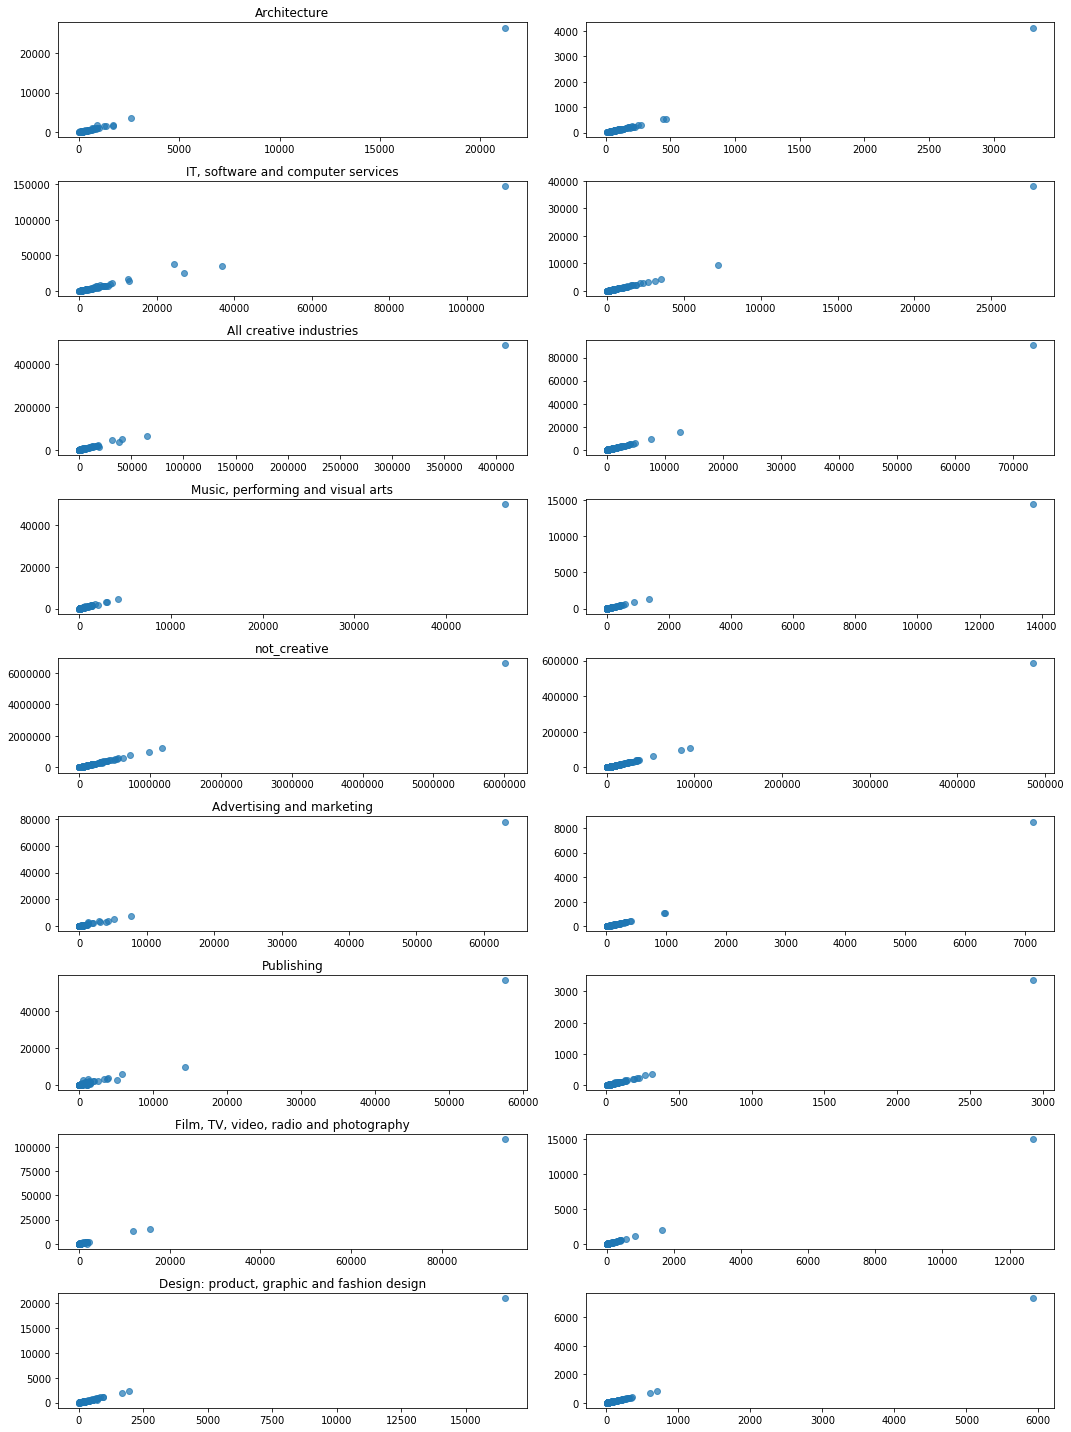

In [116]:
fig, ax = plt.subplots(nrows=len(set(idbr_fe_out.industry)),ncols=2,figsize=(15,20))


for num,x in enumerate(set(idbr_fe_out.industry)):
    print(x)
    
    data = idbr_fe_out.loc[idbr_fe_out.industry==x,:]
    
    emp_data = pd.pivot_table(data,index='ttwa_name',columns='year',values='employment').dropna()
    
    ax[num][0].scatter(emp_data['2011_2014'],emp_data['2015_2016'],alpha=0.7)
    
    ax[num][0].set_title(x)
    
    bc_data = pd.pivot_table(data,index='ttwa_name',columns='year',values='business_count').dropna()
    
    ax[num][1].scatter(bc_data['2011_2014'],bc_data['2015_2016'],alpha=0.7)
    
plt.tight_layout()

In [117]:
it = idbr_fe_out.loc[idbr_fe_out.industry=='All creative industries',:]


it_emp_data = pd.pivot_table(data,index='ttwa_name',columns='year',values='employment').dropna()

it_emp_data['gr']=it_emp_data['2015_2016']/it_emp_data['2011_2014']

it_emp_data.sort_values('gr',ascending=False)

year,2011_2014,2015_2016,gr
ttwa_name,,,
Swansea,98.50,210.0,2.131980
King's Lynn,48.50,100.0,2.061856
Harrogate,177.00,290.0,1.638418
Newry and Banbridge,43.25,70.0,1.618497
Kingsbridge and Dartmouth,22.00,35.0,1.590909
Evesham,74.50,115.0,1.543624
Banbury,134.50,200.0,1.486989
Dundee,135.75,200.0,1.473297
Redruth and Truro,110.25,160.0,1.451247


### Extract IDBR data

In [ ]:
#We use the Nomis API
#Our queries return more results than Nomis can handle so we will have to split them.

#First we extract data by year and sic code. 

all_sizes_link = 'http://www.nomisweb.co.uk/api/v01/dataset/NM_141_1.data.csv?geography=1874854111,1874853904,1874853931,1874853936,1874853949,1874853952,1874853980,1874853984,1874854016,1874853894,1874853899,1874853901,1874853902,1874853914,1874854112,1874854113,1874853929,1874853959,1874853963,1874853970,1874853976,1874853990,1874853996,1874854026,1874854029,1874854033,1874853892,1874853907,1874853909,1874853933,1874853945,1874853947,1874853948,1874853954,1874853955,1874853966,1874853975,1874853985,1874854000...1874854002,1874854006,1874854025,1874854028,1874854037,1874853905,1874853917,1874853922,1874853926,1874853932,1874853943,1874853960,1874853967,1874853968,1874853977,1874853986,1874853988,1874854005,1874854010,1874854034,1874853900,1874853915,1874853927,1874853935,1874853951,1874853965,1874853973,1874854116,1874854003,1874854012,1874854014,1874854019,1874854031,1874854032,1874853897,1874853916,1874853918,1874853920,1874853924,1874853925,1874853930,1874853944,1874853956,1874853957,1874853961,1874853972,1874853974,1874853987,1874853992,1874854009,1874854013,1874854020,1874854030,1874853971,1874853889...1874853891,1874853895,1874853911,1874853919,1874853923,1874853928,1874853937,1874853941,1874853946,1874853950,1874853953,1874853958,1874853978,1874853979,1874853981,1874853983,1874853989,1874853995,1874853997,1874854007,1874854008,1874854023,1874854035,1874853893,1874853896,1874853898,1874853903,1874853906,1874853908,1874853910,1874853912,1874853913,1874853921,1874854114,1874853934,1874853938...1874853940,1874853942,1874853962,1874853964,1874853969,1874853982,1874853991,1874853993,1874853994,1874853998,1874853999,1874854004,1874854011,1874854015,1874854017,1874854018,1874854021,1874854022,1874854024,1874854027,1874854036,1874854038...1874854048,1874854115,1874854049...1874854069,1874854071...1874854099,1874854070,1874854100...1874854110&date=latestMINUS1-latest&industry=138412132,138412143...138412148,138412151,138412153...138412162,138412173...138412179,138412181,138412182,138412193...138412196,138412202,138412242,138412252,138412262,138412272,138412343,138412344,138412353,138412354,138412542,138412552,138412642,138412652,138412742,138412753,138412761,138412843,138412844,138412923...138412925,138412931,138412942,138413022,138413043...138413045,138413052,138413063,138413064,138413071,138413073,138413074,138413083,138413084,138413093,138413094,138413103...138413105,138413113...138413118,138413121,138413123,138413124,138413133...138413139,138413232,138413342,138413352,138413362,138413423...138413428,138413431,138413443...138413446,138413451,138413452,138413463,138413471,138413543,138413544,138413552,138413642,138413653...138413656,138413661,138413743,138413744,138413753...138413756,138413761,138413843...138413846,138413852,138413942,138413952,138414043...138414049,138414052,138414062,138414073,138414074,138414083...138414085,138414091,138414092,138414142,138414152,138414243,138414251,138414253...138414255,138414261,138414343...138414346,138414351,138414352,138414363,138414364,138414373...138414376,138414381,138414383,138414384,138414393...138414397,138414401,138414402,138414423,138414431,138414442,138414452,138414463...138414466,138414473...138414478,138414483...138414486,138414543,138414544,138414553,138414561,138414562,138414572,138414582,138414593,138414594,138414603...138414605,138414623...138414626,138414631,138414643,138414644,138414652,138414662,138414672,138414683,138414684,138414692,138414702,138414712,138414743,138414744,138414752,138414763...138414765,138414772,138414783,138414784,138414822,138414843...138414847,138414853...138414857,138414861,138414862,138414873,138414881,138414923...138414928,138414931,138414942,138414952,138414963,138414964,138415043,138415044,138415052,138415062,138415072,138415123,138415124,138415131,138415133...138415135,138415141,138415243...138415245,138415252,138415262,138415272,138415282,138415323,138415331,138415343...138415349,138415351,138415352,138415543...138415546,138415553...138415555,138415562,138415632,138415732,138415843,138415844,138415853,138415854,138415863,138415864,138415932,138416142,138416152,138416243...138416245,138416253,138416254,138416323,138416331,138416343...138416345,138416353,138416354,138416361,138416363...138416366,138416371,138416423,138416431,138416543,138416551,138416552,138416563,138416564,138416572,138416643...138416651,138416653...138416656,138416663...138416671,138416673...138416681,138416683,138416684,138416693...138416698,138416701,138416703...138416709,138416722,138416743,138416751,138416753...138416758,138416761,138416762,138416773...138416775,138416783...138416786,138416791,138416793...138416797,138416803...138416811,138416813,138416814,138416821,138416823,138416831,138416942,138416952,138416963,138416964,138416971,138416973,138416974,138416982,138417042,138417052,138417062,138417072,138417142,138417153,138417154,138417242,138417253...138417256,138417261,138417342,138417352,138417542,138417552,138417562,138417622,138417642,138417653,138417661,138417662,138417843...138417846,138417851,138417853,138417861,138417943...138417946,138417952,138418042,138418052,138418142,138418152,138418162,138418222,138418233...138418235,138418241,138418343,138418344,138418423,138418431,138418443,138418451,138418452,138418462,138418523,138418524,138418531,138418543,138418544,138418552,138418562,138418643,138418644,138418651,138418653,138418654,138418661,138418662,138418842,138418852,138418863,138418864,138418942,138418952,138419042,138419053,138419054,138419143,138419144,138419152,138419243,138419251,138419252,138419343,138419344,138419352,138419442,138419452,138419462,138419522,138419532,138419743,138419744,138419753,138419754,138419761,138419763...138419767,138419771,138419772,138419842,138419852,138419862,138419943,138419944,138420022,138420042,138420052,138420062,138420142,138420153,138420154,138420161,138420162,138420243,138420251,138420252,138420262,138420323,138420324,138420331,138420443...138420445,138420453...138420457,138420462,138420542,138420552,138420563,138420564,138420573,138420574,138420583...138420585,138420591,138420592,138420642,138420653...138420655,138420722,138420742,138420752,138420762,138420822,138420842,138420923,138420931,138421033...138421036,138421133...138421136,138421232,138421343...138421345,138421351,138421353,138421361,138421443,138421444,138421452,138421523,138421524,138421531,138421543,138421544,138421553...138421557,138421561,138421633...138421636,138421641,138421732,138421842,138421852,138421932&employment_sizeband=0&legal_status=0&measures=20100&select=date_name,geography_name,geography_code,industry_name,employment_sizeband_name,legal_status_name,measures_name,obs_value,obs_status_name'

In [7]:
all_sizes_activity = QueryNomis(link=all_sizes_link,total_records=280896)
all_sizes_activity.query_nomis()

280896
255896
230896
205896
180896
155896
130896
105896
80896
55896
30896
5896


In [8]:
idbr_total_df = all_sizes_activity.output_data

In [9]:
#This is the link for the 2016 data with sizebands
sizes_2016_link = "http://www.nomisweb.co.uk/api/v01/dataset/NM_141_1.data.csv?geography=1874854111,1874853904,1874853931,1874853936,1874853949,1874853952,1874853980,1874853984,1874854016,1874853894,1874853899,1874853901,1874853902,1874853914,1874854112,1874854113,1874853929,1874853959,1874853963,1874853970,1874853976,1874853990,1874853996,1874854026,1874854029,1874854033,1874853892,1874853907,1874853909,1874853933,1874853945,1874853947,1874853948,1874853954,1874853955,1874853966,1874853975,1874853985,1874854000...1874854002,1874854006,1874854025,1874854028,1874854037,1874853905,1874853917,1874853922,1874853926,1874853932,1874853943,1874853960,1874853967,1874853968,1874853977,1874853986,1874853988,1874854005,1874854010,1874854034,1874853900,1874853915,1874853927,1874853935,1874853951,1874853965,1874853973,1874854116,1874854003,1874854012,1874854014,1874854019,1874854031,1874854032,1874853897,1874853916,1874853918,1874853920,1874853924,1874853925,1874853930,1874853944,1874853956,1874853957,1874853961,1874853972,1874853974,1874853987,1874853992,1874854009,1874854013,1874854020,1874854030,1874853971,1874853889...1874853891,1874853895,1874853911,1874853919,1874853923,1874853928,1874853937,1874853941,1874853946,1874853950,1874853953,1874853958,1874853978,1874853979,1874853981,1874853983,1874853989,1874853995,1874853997,1874854007,1874854008,1874854023,1874854035,1874853893,1874853896,1874853898,1874853903,1874853906,1874853908,1874853910,1874853912,1874853913,1874853921,1874854114,1874853934,1874853938...1874853940,1874853942,1874853962,1874853964,1874853969,1874853982,1874853991,1874853993,1874853994,1874853998,1874853999,1874854004,1874854011,1874854015,1874854017,1874854018,1874854021,1874854022,1874854024,1874854027,1874854036,1874854038...1874854048,1874854115,1874854049...1874854069,1874854071...1874854099,1874854070,1874854100...1874854110&date=latestMINUS1&industry=138412132,138412143...138412148,138412151,138412153...138412162,138412173...138412179,138412181,138412182,138412193...138412196,138412202,138412242,138412252,138412262,138412272,138412343,138412344,138412353,138412354,138412542,138412552,138412642,138412652,138412742,138412753,138412761,138412843,138412844,138412923...138412925,138412931,138412942,138413022,138413043...138413045,138413052,138413063,138413064,138413071,138413073,138413074,138413083,138413084,138413093,138413094,138413103...138413105,138413113...138413118,138413121,138413123,138413124,138413133...138413139,138413232,138413342,138413352,138413362,138413423...138413428,138413431,138413443...138413446,138413451,138413452,138413463,138413471,138413543,138413544,138413552,138413642,138413653...138413656,138413661,138413743,138413744,138413753...138413756,138413761,138413843...138413846,138413852,138413942,138413952,138414043...138414049,138414052,138414062,138414073,138414074,138414083...138414085,138414091,138414092,138414142,138414152,138414243,138414251,138414253...138414255,138414261,138414343...138414346,138414351,138414352,138414363,138414364,138414373...138414376,138414381,138414383,138414384,138414393...138414397,138414401,138414402,138414423,138414431,138414442,138414452,138414463...138414466,138414473...138414478,138414483...138414486,138414543,138414544,138414553,138414561,138414562,138414572,138414582,138414593,138414594,138414603...138414605,138414623...138414626,138414631,138414643,138414644,138414652,138414662,138414672,138414683,138414684,138414692,138414702,138414712,138414743,138414744,138414752,138414763...138414765,138414772,138414783,138414784,138414822,138414843...138414847,138414853...138414857,138414861,138414862,138414873,138414881,138414923...138414928,138414931,138414942,138414952,138414963,138414964,138415043,138415044,138415052,138415062,138415072,138415123,138415124,138415131,138415133...138415135,138415141,138415243...138415245,138415252,138415262,138415272,138415282,138415323,138415331,138415343...138415349,138415351,138415352,138415543...138415546,138415553...138415555,138415562,138415632,138415732,138415843,138415844,138415853,138415854,138415863,138415864,138415932,138416142,138416152,138416243...138416245,138416253,138416254,138416323,138416331,138416343...138416345,138416353,138416354,138416361,138416363...138416366,138416371,138416423,138416431,138416543,138416551,138416552,138416563,138416564,138416572,138416643...138416651,138416653...138416656,138416663...138416671,138416673...138416681,138416683,138416684,138416693...138416698,138416701,138416703...138416709,138416722,138416743,138416751,138416753...138416758,138416761,138416762,138416773...138416775,138416783...138416786,138416791,138416793...138416797,138416803...138416811,138416813,138416814,138416821,138416823,138416831,138416942,138416952,138416963,138416964,138416971,138416973,138416974,138416982,138417042,138417052,138417062,138417072,138417142,138417153,138417154,138417242,138417253...138417256,138417261,138417342,138417352,138417542,138417552,138417562,138417622,138417642,138417653,138417661,138417662,138417843...138417846,138417851,138417853,138417861,138417943...138417946,138417952,138418042,138418052,138418142,138418152,138418162,138418222,138418233...138418235,138418241,138418343,138418344,138418423,138418431,138418443,138418451,138418452,138418462,138418523,138418524,138418531,138418543,138418544,138418552,138418562,138418643,138418644,138418651,138418653,138418654,138418661,138418662,138418842,138418852,138418863,138418864,138418942,138418952,138419042,138419053,138419054,138419143,138419144,138419152,138419243,138419251,138419252,138419343,138419344,138419352,138419442,138419452,138419462,138419522,138419532,138419743,138419744,138419753,138419754,138419761,138419763...138419767,138419771,138419772,138419842,138419852,138419862,138419943,138419944,138420022,138420042,138420052,138420062,138420142,138420153,138420154,138420161,138420162,138420243,138420251,138420252,138420262,138420323,138420324,138420331,138420443...138420445,138420453...138420457,138420462,138420542,138420552,138420563,138420564,138420573,138420574,138420583...138420585,138420591,138420592,138420642,138420653...138420655,138420722,138420742,138420752,138420762,138420822,138420842,138420923,138420931,138421033...138421036,138421133...138421136,138421232,138421343...138421345,138421351,138421353,138421361,138421443,138421444,138421452,138421523,138421524,138421531,138421543,138421544,138421553...138421557,138421561,138421633...138421636,138421641,138421732,138421842,138421852,138421932&employment_sizeband=10,20,30,40&legal_status=0&measures=20100&select=date_name,geography_name,geography_code,industry_name,employment_sizeband_name,legal_status_name,measures_name,obs_value,obs_status_name"

#Initialise the object
sizes_2016 = QueryNomis(link=sizes_2016_link,total_records=561792)

#Run the query
sizes_2016.query_nomis()

#Extract the df
idbr_sizebands_2016_df = sizes_2016.output_data

561792
536792
511792
486792
461792
436792
411792
386792
361792
336792
311792
286792
261792
236792
211792
186792
161792
136792
111792
86792
61792
36792
11792


In [16]:
idbr_totals_obj = ProcessNomisAPi(idbr_total_df)
idbr_totals_obj.process_data()
idbr_totals_obj.gather_data()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
#And we do the same thing for the 2017 data with sizebands
sizes_2017_link = "http://www.nomisweb.co.uk/api/v01/dataset/NM_141_1.data.csv?geography=1874854111,1874853904,1874853931,1874853936,1874853949,1874853952,1874853980,1874853984,1874854016,1874853894,1874853899,1874853901,1874853902,1874853914,1874854112,1874854113,1874853929,1874853959,1874853963,1874853970,1874853976,1874853990,1874853996,1874854026,1874854029,1874854033,1874853892,1874853907,1874853909,1874853933,1874853945,1874853947,1874853948,1874853954,1874853955,1874853966,1874853975,1874853985,1874854000...1874854002,1874854006,1874854025,1874854028,1874854037,1874853905,1874853917,1874853922,1874853926,1874853932,1874853943,1874853960,1874853967,1874853968,1874853977,1874853986,1874853988,1874854005,1874854010,1874854034,1874853900,1874853915,1874853927,1874853935,1874853951,1874853965,1874853973,1874854116,1874854003,1874854012,1874854014,1874854019,1874854031,1874854032,1874853897,1874853916,1874853918,1874853920,1874853924,1874853925,1874853930,1874853944,1874853956,1874853957,1874853961,1874853972,1874853974,1874853987,1874853992,1874854009,1874854013,1874854020,1874854030,1874853971,1874853889...1874853891,1874853895,1874853911,1874853919,1874853923,1874853928,1874853937,1874853941,1874853946,1874853950,1874853953,1874853958,1874853978,1874853979,1874853981,1874853983,1874853989,1874853995,1874853997,1874854007,1874854008,1874854023,1874854035,1874853893,1874853896,1874853898,1874853903,1874853906,1874853908,1874853910,1874853912,1874853913,1874853921,1874854114,1874853934,1874853938...1874853940,1874853942,1874853962,1874853964,1874853969,1874853982,1874853991,1874853993,1874853994,1874853998,1874853999,1874854004,1874854011,1874854015,1874854017,1874854018,1874854021,1874854022,1874854024,1874854027,1874854036,1874854038...1874854048,1874854115,1874854049...1874854069,1874854071...1874854099,1874854070,1874854100...1874854110&date=latest&industry=138412132,138412143...138412148,138412151,138412153...138412162,138412173...138412179,138412181,138412182,138412193...138412196,138412202,138412242,138412252,138412262,138412272,138412343,138412344,138412353,138412354,138412542,138412552,138412642,138412652,138412742,138412753,138412761,138412843,138412844,138412923...138412925,138412931,138412942,138413022,138413043...138413045,138413052,138413063,138413064,138413071,138413073,138413074,138413083,138413084,138413093,138413094,138413103...138413105,138413113...138413118,138413121,138413123,138413124,138413133...138413139,138413232,138413342,138413352,138413362,138413423...138413428,138413431,138413443...138413446,138413451,138413452,138413463,138413471,138413543,138413544,138413552,138413642,138413653...138413656,138413661,138413743,138413744,138413753...138413756,138413761,138413843...138413846,138413852,138413942,138413952,138414043...138414049,138414052,138414062,138414073,138414074,138414083...138414085,138414091,138414092,138414142,138414152,138414243,138414251,138414253...138414255,138414261,138414343...138414346,138414351,138414352,138414363,138414364,138414373...138414376,138414381,138414383,138414384,138414393...138414397,138414401,138414402,138414423,138414431,138414442,138414452,138414463...138414466,138414473...138414478,138414483...138414486,138414543,138414544,138414553,138414561,138414562,138414572,138414582,138414593,138414594,138414603...138414605,138414623...138414626,138414631,138414643,138414644,138414652,138414662,138414672,138414683,138414684,138414692,138414702,138414712,138414743,138414744,138414752,138414763...138414765,138414772,138414783,138414784,138414822,138414843...138414847,138414853...138414857,138414861,138414862,138414873,138414881,138414923...138414928,138414931,138414942,138414952,138414963,138414964,138415043,138415044,138415052,138415062,138415072,138415123,138415124,138415131,138415133...138415135,138415141,138415243...138415245,138415252,138415262,138415272,138415282,138415323,138415331,138415343...138415349,138415351,138415352,138415543...138415546,138415553...138415555,138415562,138415632,138415732,138415843,138415844,138415853,138415854,138415863,138415864,138415932,138416142,138416152,138416243...138416245,138416253,138416254,138416323,138416331,138416343...138416345,138416353,138416354,138416361,138416363...138416366,138416371,138416423,138416431,138416543,138416551,138416552,138416563,138416564,138416572,138416643...138416651,138416653...138416656,138416663...138416671,138416673...138416681,138416683,138416684,138416693...138416698,138416701,138416703...138416709,138416722,138416743,138416751,138416753...138416758,138416761,138416762,138416773...138416775,138416783...138416786,138416791,138416793...138416797,138416803...138416811,138416813,138416814,138416821,138416823,138416831,138416942,138416952,138416963,138416964,138416971,138416973,138416974,138416982,138417042,138417052,138417062,138417072,138417142,138417153,138417154,138417242,138417253...138417256,138417261,138417342,138417352,138417542,138417552,138417562,138417622,138417642,138417653,138417661,138417662,138417843...138417846,138417851,138417853,138417861,138417943...138417946,138417952,138418042,138418052,138418142,138418152,138418162,138418222,138418233...138418235,138418241,138418343,138418344,138418423,138418431,138418443,138418451,138418452,138418462,138418523,138418524,138418531,138418543,138418544,138418552,138418562,138418643,138418644,138418651,138418653,138418654,138418661,138418662,138418842,138418852,138418863,138418864,138418942,138418952,138419042,138419053,138419054,138419143,138419144,138419152,138419243,138419251,138419252,138419343,138419344,138419352,138419442,138419452,138419462,138419522,138419532,138419743,138419744,138419753,138419754,138419761,138419763...138419767,138419771,138419772,138419842,138419852,138419862,138419943,138419944,138420022,138420042,138420052,138420062,138420142,138420153,138420154,138420161,138420162,138420243,138420251,138420252,138420262,138420323,138420324,138420331,138420443...138420445,138420453...138420457,138420462,138420542,138420552,138420563,138420564,138420573,138420574,138420583...138420585,138420591,138420592,138420642,138420653...138420655,138420722,138420742,138420752,138420762,138420822,138420842,138420923,138420931,138421033...138421036,138421133...138421136,138421232,138421343...138421345,138421351,138421353,138421361,138421443,138421444,138421452,138421523,138421524,138421531,138421543,138421544,138421553...138421557,138421561,138421633...138421636,138421641,138421732,138421842,138421852,138421932&employment_sizeband=10,20,30,40&legal_status=0&measures=20100&select=date_name,geography_name,geography_code,industry_name,employment_sizeband_name,legal_status_name,measures_name,obs_value,obs_status_name"

#Initialise the object
sizes_2017 = QueryNomis(link=sizes_2017_link,total_records=561792)

#Run the query
sizes_2017.query_nomis()

#Extract the df
idbr_sizebands_2017_df = sizes_2017.output_data

561792
536792
511792
486792
461792
436792
411792
386792
361792
336792
311792
286792
261792
236792
211792
186792
161792
136792
111792
86792
61792
36792
11792


In [11]:
#Now we need to process the idbr data. What is the best format?

class ProcessNomisAPi():
    '''
    What processing is required? Change variable names, combine with sic data and aggregate over a 
    sic codes as we did with the bres data.
    
    '''
    
    def __init__(self,data):
        '''
        We feed the data into the class
        
        '''
        
        self.data = data
        
    def process_data(self,names=['year','ttwa_name','ttwa_code','sic','sizeband','value']):
        '''
        Data processing includes removing irrelevant columns 
        
        '''
        
        #Read data
        data = self.data
        
        #Remove irrelevant columns
        data = data.iloc[:,[0,1,2,3,4,7]]
        
        #Rename tidier
        data.columns = names
        
        #Clean sic codes
        data['sic'] = [x.split(":")[0].strip() for x in data['sic']]
        
        #Clean
        self.processed_data = data
    
    def gather_data(self,sector_lookup=creative_lookup,sector_totals=True,sector_name='creative_industries'):
        '''
        Gather the data with the creative lookup
        
        '''
        
        #Read the data
        data = self.processed_data
        
        #Merge with the creative data
        data_merged = pd.merge(data,creative_lookup,
                              left_on='sic',right_on='sic',how='outer')
        
        data_merged['sector'].fillna('not_in_sector',inplace=True)
        
        #Extract the sectoral values
        sectoral_sizeband_stats = data_merged.groupby(['year','ttwa_name','ttwa_code',
                                                       'sizeband','sector'])['value'].sum().reset_index(drop=False)
        
        
        #Extract the CI values
        all_cis_sizeband_stats = data_merged.loc[
            [x != 'not_in_sector' for x in data_merged['sector']],:].groupby(
            ['year','ttwa_name','ttwa_code','sizeband'])['value'].sum().reset_index(drop=False)
        
        
        all_cis_sizeband_stats['sector'] = sector_name
        
        #Combine and output
        all_data = pd.concat([sectoral_sizeband_stats,all_cis_sizeband_stats])
        
        self.gathered_data =all_data
        
        #return(all_data)


In [12]:
#Extract the sizeband data
sizebands_obj = ProcessNomisAPi(pd.concat([idbr_sizebands_2016_df,idbr_sizebands_2017_df]))
sizebands_obj.process_data()
sizebands_obj.gather_data()

idbr_sizebands_df = sizebands_obj.gathered_data

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
#Save data

idbr_totals_obj.gathered_data.to_csv(int_data+'/{date}_idbr_totals.csv'.format(date=today_str),index=False)
idbr_sizebands_df.to_csv(int_data+'/{date}_idbr_sizeband.csv'.format(date=today_str),index=False)


# Robustness checks

## Check 1: Make sure we didn't mess up during data processing

Check that the BRES statistics we have extracted are indeed correct. We work with the 'non-converted' BRES data and compare with the processed BRES data

In [33]:
#read the BRES data

bres_1, bres_2 = [pd.read_csv(ext_data+'/bres_{y}.csv'.format(
    y=y),skiprows=8).set_index('travel to work area 2011-based').drop('mnemonic',axis=1) for y in [2015,2016]]

#Change column names
bres_1.columns, bres_2.columns = [[x.split(" :")[0] for x in data] for data in [bres_1,bres_2]]

In [34]:
#Software codes
it_codes = list(creative_lookup.sic[creative_lookup.sector=='IT, software and computer services'])

In [35]:
#Get Cardiff
cardiff_creative_stats = pd.concat([x.loc['Cardiff',
                                         [val for val in x.columns if val in it_codes]] for x in [bres_1,bres_2]],
                                  axis=1)

swansea_creative_stats = pd.concat([x.loc['Swansea',
                                         [val for val in x.columns if val in it_codes]] for x in [bres_1,bres_2]],
                                  axis=1)

In [36]:
cardiff_creative_stats.sum(axis=0)

Cardiff    1765.0
Cardiff    4300.0
dtype: float64

In [37]:
swansea_creative_stats.sum(axis=0)

Swansea     915.0
Swansea    1795.0
dtype: float64

In [46]:
#How does this compare with the other BRES numbers

for x in ['Cardiff','Swansea']:
    print(x)
    print(bres_totals_df.loc[x,'IT, software and computer services'])

Cardiff
ttwa_code
W22000024    1765.0
W22000024    4300.0
Name: IT, software and computer services, dtype: float64
Swansea
ttwa_code
W22000032     915.0
W22000032    1795.0
Name: IT, software and computer services, dtype: float64


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.


Ok so it all checks. It's not a problem with the data processing

## Check 2: compare employee and employment figures

In [101]:
#Get Welsh TTWAs

welsh_ttwas = set([x[0] for x in bres_totals_df.index if x[1][0]=='W'])

In [102]:
#Extract bres_data with employees
bres_data_employees = [BresData(ext_data+'/bres_employees_{y}.csv'.format(
    y=x),year=x).read_clean_data().gather_by_sector(creative_lookup) for x in ['2015','2016']]


bres_totals_employees_df = pd.concat([x.gathered_data for x in bres_data_employees])

#bres_totals_df.to_csv(ext_data+'/bres_creative_2015_16.csv')

In [103]:
#We calculate the differences between employment and employee stat in every TTWA
#Contaner
bres_employment_employee_diff = []

#Loop
for x in welsh_ttwas:
    #What is the difference between estimates based on employees and employment?
    difference = bres_totals_df.loc[x,:].T.iloc[:-1,:]- bres_totals_employees_df.loc[x,:].T.iloc[:-1,:]
    difference.columns= [2015,2016]
    
    bres_employment_employee_diff.append(difference.reset_index(drop=False))
    

employment_diff_all_conc = pd.concat(bres_employment_employee_diff)


In [104]:
#At least in Cardiff, the employment measure seems to vastly increase the number of people working in IT in
#one period but not another.
employment_diff_all_conc.groupby('sector').sum()

,2015,2016
sector,,
Advertising and marketing,155.0,10.0
Architecture,30.0,0.0
Crafts,0.0,0.0
Design,20.0,30.0
"Film, TV, video, radio and photography",200.0,20.0
"IT, software and computer services",0.0,1055.0
"Museums, galleries and libraries",0.0,0.0
"Music, performing and visual arts",465.0,270.0
Publishing,110.0,25.0


Could the employment figures generate flakiness? The change in 2015 was about including companies with a single PAYE account (companies that employ a single owner-worker).
We can report 2015 and 2016 averages in employment and changes in employees between 2015 and 2016

In [182]:
bres_totals_employees_df.to_csv(ext_data+'/{y}_bres_employee_data.csv'.format(y=today_str))

## Check 3: compare growth in IDBR employment and BRES employment

In [154]:
#We load frontier economics IDBR data for that

#These are the variables we want to focus on
my_variables = ['industry','TTWA name','Employment','Year']

#Load the first frontier extract (NB these are enterprises, not local units)
front_idbr_extract = pd.read_excel(
    ext_data+'/frontier/spd-creative clusters counts and LQs-06-11-2017.xlsx',sheetname=4)[
    my_variables]

front_idbr_extract['industry'] = [x if ':' not in x else 'Design' for x in front_idbr_extract['industry']]

frontier_emp_growth = pd.pivot_table(front_idbr_extract,index=['TTWA name','industry'],
                                    columns='Year',values='Employment')

frontier_emp_growth['idbr_change'] = frontier_emp_growth[2016]/frontier_emp_growth[2015]  

#Now compare to BRES




/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [173]:
#OUCH!
bres_emp_growth = pd.pivot_table(pd.melt(bres_totals_employees_df.reset_index(drop=False).drop('ttwa_code',axis=1),
                                         id_vars=['ttwa_name','year']),
                                 index=['ttwa_name','sector'],columns='year',values='value')

bres_emp_growth['bres_change'] = bres_emp_growth['2016']/bres_emp_growth['2015']

In [174]:
#Concatenated

growth_comparison = pd.concat([frontier_emp_growth['idbr_change'],
                               bres_emp_growth['bres_change']],axis=1).reset_index(drop=False).dropna()

growth_comparison.rename(columns={'level_0':'ttwa_name','level_1':'sector'},inplace=True)

In [175]:
growth_correlations = []


for x in set(growth_comparison.sector):
    sector_corr = growth_comparison.loc[growth_comparison.sector==x,:].iloc[:,2:].corr()
    
    growth_correlations.append([x,sector_corr])


In [178]:
# :-(
#Not sure we are correlating the right periods and variables
growth_correlations

[['Design',              idbr_change  bres_change
  idbr_change     1.000000     0.143487
  bres_change     0.143487     1.000000],
 ['Music, performing and visual arts',              idbr_change  bres_change
  idbr_change     1.000000    -0.028394
  bres_change    -0.028394     1.000000],
 ['Publishing',              idbr_change  bres_change
  idbr_change     1.000000    -0.164414
  bres_change    -0.164414     1.000000],
 ['Film, TV, video, radio and photography',
               idbr_change  bres_change
  idbr_change     1.000000     0.022848
  bres_change     0.022848     1.000000],
 ['IT, software and computer services',              idbr_change  bres_change
  idbr_change     1.000000    -0.015399
  bres_change    -0.015399     1.000000],
 ['Architecture',              idbr_change  bres_change
  idbr_change     1.000000     0.348532
  bres_change     0.348532     1.000000],
 ['Advertising and marketing',              idbr_change  bres_change
  idbr_change     1.000000     0.404176


In [184]:
12+12.30+154

178.3